This notebook is the Mean Reversion trading strategy for Sebastian Usai's capstone project with WQU.

The first half of this notebook presents a simple mean reversion trading strategy.

The second half works off the output files from the first part of the notebook. These files were edited by hand based on the machine learning directional filter. Any trades taken in the opposite direction of the ML filter were removed from the files.

In [12]:
### LIBRARIES   ###

import datetime as dt
import matplotlib.pyplot as plt
from matplotlib import style
import pandas as pd
import pandas_datareader.data as web
import matplotlib.dates as mdates
style.use ('ggplot')
import numpy as np
from scipy.stats import skew
from scipy.stats import kurtosis

In [13]:
df = pd.read_csv('EURUSD5.csv', parse_dates = True, index_col=0)
df=df.rename(columns = {'1.12349':'Open'})
df=df.rename(columns = {'1.12374':'High'})
df=df.rename(columns = {'1.12349.1':'Low'})
df=df.rename(columns = {'1.12372':'Close'})
df=df.rename(columns = {'161':'Volume'})
df = df.iloc[40070:-12914]

In [14]:
#LONG ONLY

#For ease of calculating results the long and short trades will be calculated seperately then combined.

#Metrics of Buy and Hold of the given asset
df['No Strategy Return'] = np.log(df['Close'] / df['Close'].shift(1))
df['Total Return'] = (1 + df['No Strategy Return']).cumprod()


lookback = 1000

# Calculate the max drawdown in the past window days for each day 
df['rolling_max'] = df['Total Return'].rolling(lookback, min_periods=1).max()
df['daily_drawdown'] = df['Total Return']/df['rolling_max'] - 1.0

# Calculate the minimum (negative) daily drawdown
df['max_daily_drawdown'] = df['daily_drawdown'].rolling(lookback, min_periods=1).min()

Number_of_Days = len(df.index)
CAGR = ((df['No Strategy Return'].sum())/Number_of_Days)*252
dailysharpe = df['No Strategy Return'].mean()/df['No Strategy Return'].std()

#Annualized Sharpe (daily sharpe by square root of number of trading days per year)
SharpeRatio = dailysharpe*(252**0.5)

#approx 21 trading days per month used for window
window = 20
upper_std = 2 #<  edit window(number of days in lookback period) and standard deviations here
lower_std = 2

#Calculate rolling mean and standard deviation using number of days set above
rolling_mean = df['Close'].rolling(window).mean()
rolling_std = df['Close'].rolling(window).std()

#create two new DataFrame columns to hold values of upper and lower Bollinger bands and 200ma for trend
df['Rolling Mean'] = rolling_mean
df['Bollinger High'] = rolling_mean + (rolling_std * upper_std)
df['Bollinger Low'] = rolling_mean - (rolling_std * lower_std)


#Create an "empty" column as placeholder for our /position signals
df['Position'] = None
#Fill our newly created position column - we will buy (1) for an upper band break and go to 0 on a lower band break
        
for row in range(len(df)):
    
    if (df['Close'].iloc[row] < df['Bollinger Low'].iloc[row]) and (df['Close'].iloc[row-1] > df['Bollinger Low'].iloc[row-1]):
        df['Position'].iloc[row] = 1
        
    if (df['Close'].iloc[row] > df['Bollinger High'].iloc[row]) :
        df['Position'].iloc[row] = 0
        


#Forward fill our position column to replace the "None" values with the correct long/short positions to represent the "holding" of our position
#forward through time
df['Position'].fillna(method='ffill',inplace=True)


#Calculate the daily market return and multiply that by the position to determine strategy returns
df['Market Return'] = np.log(df['Close'] / df['Close'].shift(1))
df['Strategy Return'] = df['Market Return'] * df['Position'].shift(1)
dailysharpe = df['Strategy Return'].mean()/df['Strategy Return'].std()

#Annualized Sharpe (daily sharpe by square root of number of trading days per year)
SharpeRatio = dailysharpe*(252**0.5)

#Calculate the dollar returns based on the log%'s so we can calc max DD and CAGR


df['Index Return'] = (1 + df['Strategy Return']).cumprod()

# Define a trailing 252 trading day window
lookback = 1000

# Calculate the max drawdown in the past window days for each day 
df['rolling_max'] = df['Index Return'].rolling(lookback, min_periods=1).max()
df['daily_drawdown'] = df['Index Return']/df['rolling_max'] - 1.0

# Calculate the minimum (negative) daily drawdown
df['max_daily_drawdown'] = df['daily_drawdown'].rolling(lookback, min_periods=1).min()
Regime = df['Position'].rolling(2).apply(lambda x: x[0] != x[-1], raw=True).sum().astype(int)
Buy_Orders = Regime/2
Average_Hold = (df['Position'].sum())/Buy_Orders
Number_of_Days = len(df.index)
Time_in_Market = (Average_Hold*Buy_Orders)/Number_of_Days
CAGR = ((df['Strategy Return'].sum())/Number_of_Days)*252
Regime = df['Position'].rolling(2).apply(lambda x: x[0] != x[-1], raw=True).sum().astype(int)
Buy_Orders = Regime/2
Average_Hold = (df['Position'].sum())/Buy_Orders
Number_of_Hours = len(df.index)
Time_in_Market1 = (Average_Hold*Buy_Orders)/Number_of_Hours

#Save trimmed dataframe
export_csv = df.to_csv (r'C:\Users\Seb Usai\Anaconda3\AAA WQU CF\Capstone\MeanReversionLONG.csv', index = True, header=True)

C:\Users\Seb Usai\Anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [15]:
#Now calculate the short trades
df2 = pd.read_csv('EURUSD5.csv', parse_dates = True, index_col=0)
df2=df2.rename(columns = {'1.12349':'Open'})
df2=df2.rename(columns = {'1.12374':'High'})
df2=df2.rename(columns = {'1.12349.1':'Low'})
df2=df2.rename(columns = {'1.12372':'Close'})
df2=df2.rename(columns = {'161':'Volume'})

df2 = df2.iloc[40070:-12914]

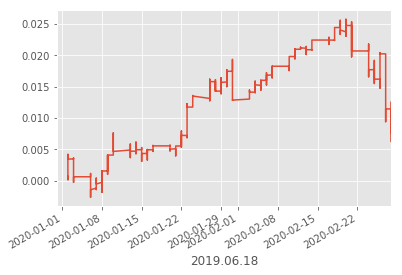

In [16]:
#Metrics of Buy and Hold of the given asset
df2['No Strategy Return'] = np.log(df2['Close'] / df2['Close'].shift(1))
df2['Total Return'] = (1 + df2['No Strategy Return']).cumprod()

#Lookback for various KPI calculations
lookback = 1000

# Calculate the max drawdown in the past window days for each day 
df2['rolling_max'] = df2['Total Return'].rolling(lookback, min_periods=1).max()
df2['daily_drawdown'] = df2['Total Return']/df2['rolling_max'] - 1.0

# Calculate the minimum (negative) daily drawdown
df2['max_daily_drawdown'] = df2['daily_drawdown'].rolling(lookback, min_periods=1).min()

Number_of_Days = len(df2.index)
CAGR = ((df2['No Strategy Return'].sum())/Number_of_Days)*252
dailysharpe = df2['No Strategy Return'].mean()/df2['No Strategy Return'].std()

#Annualized Sharpe (daily sharpe by square root of number of trading days per year)
SharpeRatio = dailysharpe*(252**0.5)

#approx 21 trading days per month used for window
window = 20
upper_std = 2 #<  edit window(number of days in lookback period) and standard deviations here
lower_std = 2
#Calculate rolling mean and standard deviation using number of days set above
rolling_mean = df2['Close'].rolling(window).mean()
rolling_std = df2['Close'].rolling(window).std()
#create two new DataFrame columns to hold values of upper and lower Bollinger bands and 200ma for trend
df2['Rolling Mean'] = rolling_mean
df2['Bollinger High'] = rolling_mean + (rolling_std * upper_std)
df2['Bollinger Low'] = rolling_mean - (rolling_std * lower_std)

#Create an "empty" column as placeholder for our /position signals
df2['Position'] = None
#Fill our newly created position column - we will buy (1) for an upper band break and go to 0 on a lower band break
        
for row in range(len(df2)):
    
    if (df2['Close'].iloc[row] > df2['Bollinger High'].iloc[row]) and (df2['Close'].iloc[row-1] < df2['Bollinger High'].iloc[row-1]) :
        df2['Position'].iloc[row] = -1
        
    if (df2['Close'].iloc[row] < df2['Bollinger Low'].iloc[row]) :
        df2['Position'].iloc[row] = 0
        


#Forward fill our position column to replace the "None" values with the correct long/short positions to represent the "holding" of our position
#forward through time
df2['Position'].fillna(method='ffill',inplace=True)
#Calculate the daily market return and multiply that by the position to determine strategy returns
df2['Market Return'] = np.log(df2['Close'] / df2['Close'].shift(1))
df2['Strategy Return'] = df2['Market Return'] * df2['Position'].shift(1)
#Plot the strategy returns
df2['Strategy Return'].cumsum().plot()

dailysharpe = df2['Strategy Return'].mean()/df2['Strategy Return'].std()

#Annualized Sharpe (daily sharpe by square root of number of trading days per year)
SharpeRatio = dailysharpe*(252**0.5)

#Calculate the dollar returns based on the log%'s so we can calc max DD and CAGR


df2['Index Return'] = (1 + df2['Strategy Return']).cumprod()

# Define a trailing 252 trading day window
lookback = 1000

# Calculate the max drawdown in the past window days for each day 
df2['rolling_max'] = df2['Index Return'].rolling(lookback, min_periods=1).max()
df2['daily_drawdown'] = df2['Index Return']/df2['rolling_max'] - 1.0

# Calculate the minimum (negative) daily drawdown
df2['max_daily_drawdown'] = df2['daily_drawdown'].rolling(lookback, min_periods=1).min()


Regime = df2['Position'].rolling(2).apply(lambda x: x[0] != x[-1], raw=True).sum().astype(int)
Buy_Orders = Regime/2

Average_Hold = (df2['Position'].sum())/Buy_Orders

Number_of_Days = len(df2.index)

Time_in_Market2 = (Average_Hold*Buy_Orders)/Number_of_Days


CAGR = ((df2['Strategy Return'].sum())/Number_of_Days)*252


Regime = df2['Position'].rolling(2).apply(lambda x: x[0] != x[-1], raw=True).sum().astype(int)
Buy_Orders = Regime/2

Average_Hold = ((df2['Position'].sum())/Buy_Orders)*-1

#Save trimmed dataframe
export_csv = df2.to_csv (r'C:\Users\Seb Usai\Anaconda3\AAA WQU CF\Capstone\MeanReversionSHORT.csv', index = True, header=True)

In [17]:
#Now combine

#Now combine and add estimated trading costs to get results
combined_return = (df['Strategy Return'] + df2['Strategy Return'])-2.0141489804411154e-06
df['Combined Return'] = combined_return
df['Combined Cumulative'] = (1 + df['Combined Return']).cumprod()


Total Return = -0.025366117693564134
PORTFOLIO CAGR= -0.1521967061613848
Max Portfolio DD =  -0.03550218898560231
TIME IN MARKET ADJUSTED CAGR= -0.15281994187941153
Percent of time in market= 0.9959217644610904


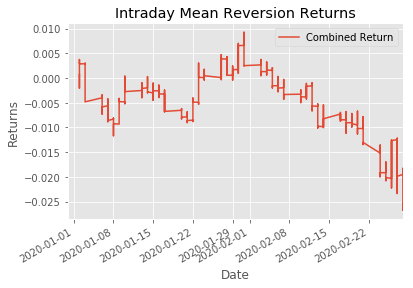

In [18]:
#Strategy Performance Metircs
Return = df['Combined Return'].sum()
CAGR = Return*6
lookback = 10000
df['rolling_maximum_combined'] = df['Combined Cumulative'].rolling(lookback, min_periods=1).max()
df['daily_drawdowns'] = df['Combined Cumulative']/df['rolling_maximum_combined'] - 1.0
df['max_daily_drawdown'] = df['daily_drawdowns'].rolling(lookback, min_periods=1).min()
Time_in_Market_Total = (Time_in_Market1-Time_in_Market2)
ADJCAGR = CAGR/Time_in_Market_Total


#### PRINT & PLOT   ###

print("Total Return =",Return)
print("PORTFOLIO CAGR=", CAGR)
print("Max Portfolio DD = ", df['max_daily_drawdown'].min())
print("TIME IN MARKET ADJUSTED CAGR=", ADJCAGR)
print("Percent of time in market=", Time_in_Market_Total)

df['Combined Return'].cumsum().plot()
plt.title("Intraday Mean Reversion Returns")
plt.xlabel("Date")
plt.ylabel("Returns")
plt.legend()

In [19]:
#Calculate Volatility
volatility = df['Combined Return'].std()
Annualised_Vol = volatility*((288*252)**0.5)
print("Volatility = ",Annualised_Vol)

#Sharpe Ratio
dailysharpe = df['Combined Return'].mean()/df['Combined Return'].std()# Sharpe Ratio
SharpeRatio = dailysharpe*((288*252)**0.5)#Annualized Sharpe (288 5minute periods per day daily sharpe by square root of number of trading days per year)
print("Sharpe Ratio = ", SharpeRatio)

skew1 = skew(df['Combined Return'].dropna())
print("Skew",skew1)

kurtosis1 = kurtosis(df['Combined Return'].dropna())
print("Kurtosis", kurtosis1)

Volatility =  0.04885200871439564
Sharpe Ratio =  -3.1495746250827743
Skew -0.4178882359777625
Kurtosis 15.219563419157627


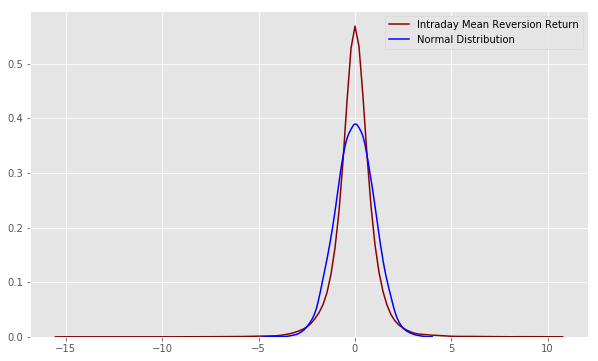

In [20]:
import seaborn as sns
returns = np.log(df['Combined Cumulative']).diff().dropna()
standard_return = (returns-returns.mean())/returns.std()

plt.figure(figsize=(10,6))
sns.kdeplot(standard_return, label="Intraday Mean Reversion Return", bw=0.30, color='darkred')
sns.kdeplot(np.random.normal(size=len(df)), label="Normal Distribution", color = 'blue')

In [21]:
#VAR
df.sort_values('Combined Return',inplace=True, ascending=True)
VAR_95=df['Combined Return'].quantile(0.05)*(288**0.5)
VAR_99=df['Combined Return'].quantile(0.01)*(288**0.5)
VAR_999=df['Combined Return'].quantile(0.001)*(288**0.5)

print("VAR at 95% confidence level = ", VAR_95)
print("VAR at 99% confidence level = ", VAR_99)
print("VAR at 99.9% confidence level = ", VAR_999)

VAR at 95% confidence level =  -0.004624252078839463
VAR at 99% confidence level =  -0.00865295580971383
VAR at 99.9% confidence level =  -0.017496946805761457


PART 2

Now that we have examined the strategy without a filter we will hand edit our long and short .csv files from above to only trade in the direction of the machine learning filter. We will import the edited files and and check the metrics in comparison to the strategy alone.

You can recreate this by first running the Capstone Machine Learning IPYNB, taking the machine learning prediction output into CapstoneML.csv and removing the counter prediction direction trades by changing the position column to 0 in the MeanreversionSHORT and MeanreversionLONG files before renaming and importing below as df3 and df4.

In [22]:
#we will now combine our long and short edited files

df3 = pd.read_csv('MeanReversionLONG1.csv', parse_dates = True, index_col=0)
df4 = pd.read_csv('MeanReversionSHORT1.csv', parse_dates = True, index_col=0)

In [23]:
#Before combining we need to calculate a couple of metircs regarding time in market

Regime3 = df3['Position'].rolling(2).apply(lambda x: x[0] != x[-1], raw=True).sum().astype(int)
Buy_Orders3 = Regime3/2
Average_Hold3 = ((df3['Position'].sum())/Buy_Orders)*-1
Number_of_periods3 = len(df3.index)
Time_in_Market3 = (Average_Hold3*Buy_Orders3)/Number_of_periods3


Regime2 = df4['Position'].rolling(2).apply(lambda x: x[0] != x[-1], raw=True).sum().astype(int)
Buy_Orders2 = Regime2/2
Average_Hold2 = ((df4['Position'].sum())/Buy_Orders2)*-1
Number_of_periods2 = len(df4.index)
Time_in_Market4 = (Average_Hold2*Buy_Orders2)/Number_of_periods2

In [24]:
#Now combine

#Now combine and subtract trading costs to get results
combined_return = (df3['Strategy Return'] + df4['Strategy Return'])-9.987515605493135e-07#trading costs/length of the index to roughly add in the costs
df3['Combined Return'] = combined_return
df3['Combined Cumulative'] = (1 + df3['Combined Return']).cumprod()

Total Return = -0.0032148534219725317
PORTFOLIO CAGR= -0.01928912053183519
Max Portfolio DD =  -0.03550218898560231
TIME IN MARKET ADJUSTED CAGR= -0.051867644912412726
Percent of time in market= 0.37189119661029774


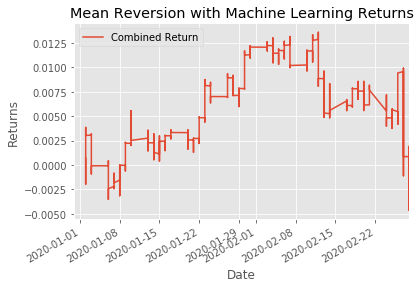

In [25]:
#Strategy Performance Metircs

Return = df3['Combined Return'].sum()
CAGR = Return*6
lookback = 10000
df3['rolling_maximum_combined'] = df3['Combined Cumulative'].rolling(lookback, min_periods=1).max()
df3['daily_drawdowns'] = df3['Combined Cumulative']/df3['rolling_maximum_combined'] - 1.0
df3['max_daily_drawdown'] = df3['daily_drawdowns'].rolling(lookback, min_periods=1).min()
Time_in_Market_Total = (-Time_in_Market3+Time_in_Market4)
ADJCAGR = CAGR/Time_in_Market_Total


#### PRINT & PLOT   ###

print("Total Return =",Return)
print("PORTFOLIO CAGR=", CAGR)
print("Max Portfolio DD = ", df['max_daily_drawdown'].min())
print("TIME IN MARKET ADJUSTED CAGR=", ADJCAGR)
print("Percent of time in market=", Time_in_Market_Total)

df3['Combined Return'].cumsum().plot()
plt.title("Mean Reversion with Machine Learning Returns")
plt.xlabel("Date")
plt.ylabel("Returns")
plt.legend()

In [26]:
#Calculate Volatility
volatility = df3['Combined Return'].std()
Annualised_Vol = volatility*((288*252)**0.5)
print("Volatility = ",Annualised_Vol)

#Sharpe Ratio
dailysharpe = df3['Combined Return'].mean()/df['Combined Return'].std()# Sharpe Ratio
SharpeRatio = dailysharpe*((288*252)**0.5)#Annualized Sharpe (288 5minute periods per day daily sharpe by square root of number of trading days per year)
print("Sharpe Ratio = ", SharpeRatio)

skew2 = skew(df3['Combined Return'].dropna())
print("Skew",skew2)

kurtosis2 = kurtosis(df3['Combined Return'].dropna())
print("Kurtosis", kurtosis2)

Volatility =  0.034555788842222
Sharpe Ratio =  -0.3991710865462405
Skew -0.3072843740174616
Kurtosis 27.10742864725944


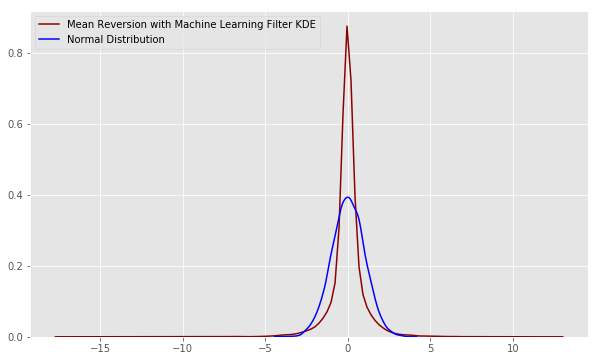

In [27]:
import seaborn as sns
returns = np.log(df3['Combined Cumulative']).diff().dropna()
standard_return = (returns-returns.mean())/returns.std()

plt.figure(figsize=(10,6))
sns.kdeplot(standard_return, label="Mean Reversion with Machine Learning Filter KDE", bw=0.30, color='darkred')
sns.kdeplot(np.random.normal(size=len(df)), label="Normal Distribution", color = 'blue')

In [28]:
#VAR
df3.sort_values('Combined Return',inplace=True, ascending=True)
VAR_95=df3['Combined Return'].quantile(0.05)*(288**0.5)
VAR_99=df3['Combined Return'].quantile(0.01)*(288**0.5)
VAR_999=df3['Combined Return'].quantile(0.001)*(288**0.5)

print("VAR at 95% confidence level = ", VAR_95)
print("VAR at 99% confidence level = ", VAR_99)
print("VAR at 99.9% confidence level = ", VAR_999)

VAR at 95% confidence level =  -0.0030903590191282476
VAR at 99% confidence level =  -0.006828413285224551
VAR at 99.9% confidence level =  -0.014818691379459707
